In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from random import random, seed, uniform, gauss

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer


In [2]:
seed(12345)
np.random.seed(12345)

In [3]:
%matplotlib inline

pd.options.display.max_rows = 250
pd.options.display.max_columns = 125
pd.options.display.max_colwidth = 250

nx_options = {
    'node_color': 'orange',
    "edge_color": "blue",
    "with_labels": True,
    "font_weight": 'bold',
    "font_size": 12,
    'node_size': 1200,
    'width': 1,
    "arrowsize": 15,
}

num_data_elts = 1_000_000
num_bins = 50


In [4]:
g = nx.DiGraph()

In [5]:
g.add_edges_from([
    ("X", "D"),
    ("B", "X"),
    ("B", "D"),
    ("D", "Y"),
    ("X", "A"),
    ("A", "C"),
    ("A", "Y"),
])

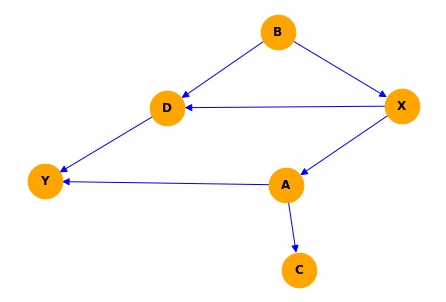

In [6]:
nx.draw_kamada_kawai(g, **nx_options)

In [7]:
X_B_coeff = 2
D_B_coeff = 3
D_X_coeff = -7
A_X_coeff = 1.25
Y_D_coeff = 1
Y_A_coeff = -1
C_A_coeff = -1


def B_value():
    return 5 * uniform(-1, 1)

def X_value(b):
    return 0.25 * X_B_coeff * b + gauss(1, 2)

def D_value(b, x):
    return D_B_coeff * b +D_X_coeff * x + gauss(23, 0.25)

def A_value(x):
    return A_X_coeff * x + gauss(1, 1)

def Y_value(d, a):
    return Y_D_coeff * d + Y_A_coeff * a + gauss(9, 4)

def C_value(a):
    return C_A_coeff * a + gauss(2, 2)

def observation():
    b = B_value()
    x = X_value(b)
    d = D_value(b, x)
    a = A_value(x)
    y = Y_value(d, a)
    c = C_value(a)
    
    return (a, b, c, d, x, y)

In [8]:
data = [observation() for _ in range(num_data_elts)]

In [9]:
df = pd.DataFrame(data, columns=["a", "b", "c", "d", "x", "y"])

In [10]:
# See the regression coefficients for predicting each variable from the others.

for node in g.nodes:
#     parents = list(g.predecessors(node))
#     print(node, parents)
    
#     if len(parents) == 0:
#         continue

    model_columns = [col.lower() for col in g.nodes if col != node]
    node = node.lower()

    x_train = df[model_columns]
    y_train = df[node]
    
    model = LinearRegression().fit(x_train, y_train)

    print(node, dict(zip(model_columns, [np.round(coeff, 5) for coeff in model.coef_])))
    print()

x {'d': -0.14253, 'b': 0.42776, 'y': 0.0, 'a': 0.00159, 'c': 2e-05}

d {'x': -6.97266, 'b': 2.98842, 'y': 0.0039, 'a': 0.00384, 'c': 0.00014}

b {'x': 2.33114, 'd': 0.3329, 'y': -0.0, 'a': 1e-05, 'c': -5e-05}

y {'x': 0.02556, 'd': 1.00427, 'b': -0.01027, 'a': -0.99839, 'c': -8e-05}

a {'x': 0.94971, 'd': 0.04703, 'b': 0.00115, 'y': -0.04744, 'c': -0.19036}

c {'x': 0.06018, 'd': 0.00898, 'b': -0.02752, 'y': -2e-05, 'a': -0.99757}



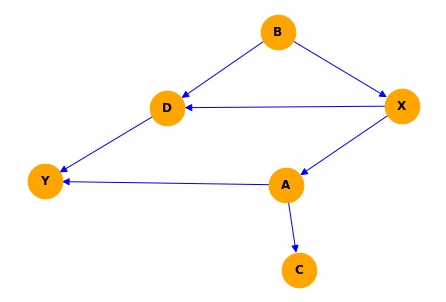

In [11]:
nx.draw_kamada_kawai(g, **nx_options)

In [12]:
binned_df = KBinsDiscretizer(n_bins=num_bins, encode="ordinal", strategy="uniform").fit_transform(df)

In [13]:
binned_df.shape, df.shape

((1000000, 6), (1000000, 6))

In [14]:
binned_df = pd.DataFrame(binned_df, columns=df.columns)

In [15]:
binned_df = binned_df.astype("int")

In [16]:
binned_df.head()

,a,b,c,d,x,y
0,32,20,20,17,33,18
1,28,8,22,20,27,20
2,23,27,24,33,18,34
3,23,7,27,23,24,23
4,35,16,22,12,36,12


If the variables in $Z$ satisfy the backdoor criterion

$$
P(Y=y | do(X=x)) = \sum_z P(Y=y | X=x, Z=z) P(Z=z) \\
= \sum_z \frac{P(Y=y, X=x, Z=z)}{P(X=x | Z=z)}
$$

In [17]:
(binned_df.x.astype("str") + " " + binned_df.b.astype("str")).nunique()

1871

In [18]:
binned_df["prob"] = 1.0

!!!!! Divide by count(Z=z)

In [19]:
p_x_z = binned_df[["x", "b", "prob"]].groupby(["x", "b"]).sum()

p_x_z.prob /= p_x_z.prob.sum()

In [20]:
p_y_x_z = binned_df[["y", "x", "b", "prob"]].groupby(["y", "x", "b"]).sum()

p_y_x_z.prob /= p_y_x_z.prob.sum()

In [21]:
p_x_z.shape, p_y_x_z.shape, binned_df.shape

((1871, 1), (12880, 1), (1000000, 7))

In [22]:
p_x_z.head()

prob
x b           
0 1   0.000002
1 1   0.000001
  2   0.000001
  3   0.000003
  14  0.000001

In [23]:
p_y_x_z.head(20)

prob
y x  b           
0 49 24  0.000001
1 49 46  0.000001
2 46 31  0.000001
3 40 9   0.000001
  43 13  0.000001
  46 37  0.000001
  47 41  0.000001
  49 48  0.000001
4 43 10  0.000001
     18  0.000001
  44 30  0.000001
  45 32  0.000001
  46 34  0.000001
     37  0.000001
     39  0.000001
     47  0.000001
  47 33  0.000001
     37  0.000001
     39  0.000003
     43  0.000002

In [24]:
# p_y_x_z["adjusted_prob"] = p_y_x_z.apply(lambda r: r.prob / p_x_z.loc[int(r.name[1])].loc[int(r.name[2])], axis=1)

In [25]:
all_freqs = pd.merge(p_y_x_z.reset_index(), p_x_z,
                     on=["x", "b"],
                     suffixes=["_xyz", "_xz"])

In [26]:
all_freqs.shape, p_y_x_z.shape, p_x_z.shape

((12880, 5), (12880, 1), (1871, 1))

In [27]:
all_freqs.head(30)

,y,x,b,prob_xyz,prob_xz
0,0,49,24,0.000001,0.000001
1,1,49,46,0.000001,0.000001
2,2,46,31,0.000001,0.000001
3,3,40,9,0.000001,0.000001
4,3,43,13,0.000001,0.000001
5,3,46,37,0.000001,0.000002
6,4,46,37,0.000001,0.000002
7,3,47,41,0.000001,0.000002
8,5,47,41,0.000001,0.000002
9,3,49,48,0.000001,0.000002


In [28]:
all_freqs["prob"] = all_freqs.prob_xyz / all_freqs.prob_xz

In [29]:
all_freqs.head()

,y,x,b,prob_xyz,prob_xz,prob
0,0,49,24,0.000001,0.000001,1.0
1,1,49,46,0.000001,0.000001,1.0
2,2,46,31,0.000001,0.000001,1.0
3,3,40,9,0.000001,0.000001,1.0
4,3,43,13,0.000001,0.000001,1.0


In [30]:
all_freqs.head(20)

,y,x,b,prob_xyz,prob_xz,prob
0,0,49,24,0.000001,0.000001,1.000000
1,1,49,46,0.000001,0.000001,1.000000
2,2,46,31,0.000001,0.000001,1.000000
3,3,40,9,0.000001,0.000001,1.000000
4,3,43,13,0.000001,0.000001,1.000000
5,3,46,37,0.000001,0.000002,0.500000
6,4,46,37,0.000001,0.000002,0.500000
7,3,47,41,0.000001,0.000002,0.500000
8,5,47,41,0.000001,0.000002,0.500000
9,3,49,48,0.000001,0.000002,0.500000


In [31]:
all_freqs.shape

(12880, 6)

In [32]:
del all_freqs["prob_xz"]
del all_freqs["prob_xyz"]
del all_freqs["b"]

In [33]:
result = all_freqs.groupby(["y", "x"]).sum()

result

prob
y  x           
0  49  1.000000
1  49  1.000000
2  46  1.000000
3  40  1.000000
   43  1.000000
   46  0.500000
   47  0.500000
   49  0.500000
4  43  2.000000
   44  1.000000
   45  1.000000
   46  1.500000
   47  3.666667
   48  1.500000
   49  0.500000
5  42  2.000000
   43  2.200000
   44  2.000000
   45  2.500000
   46  2.976190
   47  2.250000
   48  2.250000
   49  3.000000
6  37  0.333333
   38  1.250000
   39  1.444444
   40  0.583333
   41  3.382857
   42  1.569444
   43  3.583333
   44  3.415152
   45  5.716667
   46  2.833333
   47  4.333333
   48  1.000000
7  38  0.894841
   39  2.042100
   40  2.867157
   41  2.881419
   42  3.696339
   43  4.578742
   44  2.900427
   45  3.176190
   46  2.309524
   47  2.416667
   48  0.250000
8  36  0.601190
   37  1.898333
   38  3.896795
   39  3.685726
   40  5.413341
   41  4.446284
   42  5.046687
   43  3.503085
   44  5.902369
   45  3.502381
   46  1.952381
   47  0.500000
9  32  0.016393
   34  0.144211
   35  1.158502
   36  2.620759
   37  6.172887
   38  6.259416
   39  5.749017
   40  4.228272
   41  5.234314
   42  6.214196
   43  5.331477
   44  4.122708
   45  1.489683
   46  1.928571
   47  0.333333
10 32  0.019231
   33  0.128130
   34  0.704918
   35  2.338984
   36  4.124772
   37  5.455253
   38  3.850277
   39  4.727879
   40  3.710787
   41  5.251750
   42  5.032898
   43  4.595831
   44  1.480195
   45  1.515079
11 32  0.140140
   33  0.661715
   34  2.083524
   35  3.051626
   36  3.740438
   37  4.326192
   38  5.552526
   39  5.091013
   40  6.495297
   41  5.402027
   42  5.362046
   43  2.959467
   44  1.523691
   45  0.100000
12 29  0.005155
   30  0.034329
   31  0.060289
   32  0.848126
   33  2.111663
   34  4.335124
   35  5.464210
   36  5.929401
   37  5.686890
   38  5.449661
   39  5.356776
   40  5.655324
   41  4.088099
   42  2.767321
   43  0.986500
   44  0.655459
13 29  0.010257
   30  0.129298
   31  0.611732
   32  1.948873
   33  3.725901
   34  5.066038
   35  5.524079
   36  5.622876
...         ...
38 7   0.962200
   8   3.151295
   9   4.270350
   10  5.556412
   11  5.359172
   12  5.990294
   13  5.728829
   14  6.358439
   15  5.197729
   16  3.945364
   17  1.939581
   18  0.629504
   19  0.120100
   20  0.021144
39 4   0.111111
   5   0.225000
   6   1.033913
   7   3.987409
   8   4.050924
   9   5.806212
   10  5.585396
   11  5.191192
   12  5.725401
   13  6.032398
   14  5.636696
   15  3.728698
   16  2.399002
   17  0.787209
   18  0.102483
   19  0.054654
40 4   0.166667
   5   1.665278
   6   3.172281
   7   3.615122
   8   4.936042
   9   5.256226
   10  5.211332
   11  5.718688
   12  4.875492
   13  4.835954
   14  3.210974
   15  2.042049
   16  1.019892
   17  0.153272
41 4   0.444444
   5   2.011111
   6   3.745556
   7   4.294046
   8   4.603103
   9   6.065563
   10  4.229263
   11  5.246463
   12  6.552802
   13  2.935263
   14  2.627646
   15  0.783949
   16  0.009901
42 2   0.500000
   3   0.535714
   4   3.477778
   5   4.548611
   6   4.416122
   7   5.826584
   8   5.384840
   9   2.826703
   10  2.091092
   11  2.616888
   12  3.668817
   13  2.617179
   14  0.770833
   15  0.243590
   16  0.112637
43 3   1.469048
   4   2.733333
   5   6.125000
   6   4.407320
   7   6.121429
   8   1.430238
   9   6.695563
   10  6.156823
   11  1.233333
   12  2.666667
   13  0.347222
   15  0.100000
44 1   0.333333
   2   1.000000
   3   2.411905
   4   4.088889
   5   5.063889
   6   4.433333
   7   2.543694
   8   0.697619
   9   2.333333
   10  0.498352
   11  0.424242
   12  0.142857
   13  0.404762
45 0   0.500000
   1   0.333333
   3   3.583333
   4   0.977778
   5   0.361111
   6   1.783333
   7   0.400000
   8   2.000000
   9   1.500000
   10  1.000000
   11  1.000000
46 0   0.500000
   1   2.333333
   2   3.500000
   3   1.000000
   4   2.000000
   5   0.500000
   6   1.500000
   8   2.250000
   9   1.000000
   10  1.000000
47 4   1.000000
   5   0.500000
   8   1.000000
48 3   1.000000
   4   1.00

In [34]:
result.shape

(672, 1)

In [35]:
# training_fraction = 0.9
# training_size = int(training_fraction * len(data))

# model_columns = ["a", "b", "c", "d", "x"]
# model_columns = ["a", "d", "x"]

# x_train = df[model_columns][:training_size]
# y_train = df.y[:training_size]

# x_test = df[model_columns][training_size:]
# y_test = df.y[training_size:]
